# File Hashing Speed Test

This notebook tests the speed of hashing files of different sizes to understand performance characteristics.


In [ ]:
import os
import time
import hashlib
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Set up notebook-specific paths
notebook_name = '01_hash_speed_test'
results_dir = Path(f'../data/tests/{notebook_name}')
results_dir.mkdir(parents=True, exist_ok=True)
print(f'Results will be saved to: {results_dir.absolute()}')


Results will be saved to: /mnt/Dev/active_projects/neat_fs/notebooks/../data/tests/01_hash_speed_test


## Setup

Create the test directory and define file sizes to test.


In [ ]:
# Create test directory
test_dir = Path('../data/temp')
test_dir.mkdir(parents=True, exist_ok=True)

# Define file sizes to test (in bytes)
file_sizes = [
    1024,  # 1 KB
    10 * 1024,  # 10 KB
    100 * 1024,  # 100 KB
    1024 * 1024,  # 1 MB
    10 * 1024 * 1024,  # 10 MB
    100 * 1024 * 1024,  # 100 MB
    500 * 1024 * 1024,  # 500 MB
    1000 * 1024 * 1024,  # 1GB
    10 * 1024 * 1024 * 1024,  # 10GB
    20 * 1024 * 1024 * 1024,  # 20GB
]

print(f'Test directory: {test_dir.absolute()}')
print(f'File sizes to test: {[f"{size:,} bytes" for size in file_sizes]}')


Test directory: /mnt/Dev/active_projects/neat_fs/notebooks/../data/temp
File sizes to test: ['1,024 bytes', '10,240 bytes', '102,400 bytes', '1,048,576 bytes', '10,485,760 bytes', '104,857,600 bytes', '524,288,000 bytes', '1,048,576,000 bytes', '10,737,418,240 bytes', '21,474,836,480 bytes']


## Create Test Files

Generate files of different sizes with random content.


In [ ]:
def create_test_file(file_path: Path, size_bytes: int) -> None:
    """Create a test file with random content of specified size."""
    # Generate random content in chunks to avoid memory issues
    chunk_size = 1024 * 1024  # 1 MB chunks

    with open(file_path, 'wb') as f:
        remaining = size_bytes
        while remaining > 0:
            chunk = min(chunk_size, remaining)
            # Generate random bytes
            random_bytes = os.urandom(chunk)
            f.write(random_bytes)
            remaining -= chunk


# Create test files
test_files = []
for i, size in enumerate(file_sizes):
    file_path = test_dir / f'test_file_{i}_{size}.bin'
    print(f'Creating {file_path.name} ({size:,} bytes)...')
    create_test_file(file_path, size)
    test_files.append(file_path)

print(f'\nCreated {len(test_files)} test files')


Creating test_file_0_1024.bin (1,024 bytes)...
Creating test_file_1_10240.bin (10,240 bytes)...
Creating test_file_2_102400.bin (102,400 bytes)...
Creating test_file_3_1048576.bin (1,048,576 bytes)...
Creating test_file_4_10485760.bin (10,485,760 bytes)...
Creating test_file_5_104857600.bin (104,857,600 bytes)...
Creating test_file_6_524288000.bin (524,288,000 bytes)...
Creating test_file_7_1048576000.bin (1,048,576,000 bytes)...
Creating test_file_8_10737418240.bin (10,737,418,240 bytes)...
Creating test_file_9_21474836480.bin (21,474,836,480 bytes)...

Created 10 test files


## Hash Files and Measure Time

Calculate MD5 hash for each file and measure the time taken.


In [ ]:
def calculate_file_hash(file_path: Path, chunk_size: int = 8192) -> tuple[str, float]:
    """Calculate MD5 hash of a file and return hash and time taken."""
    hash_md5 = hashlib.md5()

    start_time = time.time()

    try:
        with open(file_path, 'rb') as f:
            for chunk in iter(lambda: f.read(chunk_size), b''):
                hash_md5.update(chunk)

        end_time = time.time()
        hash_value = hash_md5.hexdigest()
        time_taken = end_time - start_time

        return hash_value, time_taken

    except (IOError, OSError) as e:
        print(f'Error reading {file_path}: {e}')
        return '', 0.0


# Test hashing for each file
results = []

for file_path in test_files:
    file_size = file_path.stat().st_size
    print(f'Hashing {file_path.name} ({file_size:,} bytes)...')

    hash_value, time_taken = calculate_file_hash(
        file_path, chunk_size=100 * 1024 * 1024
    )

    # Calculate throughput (MB/s)
    throughput_mb_s = (file_size / (1024 * 1024)) / time_taken if time_taken > 0 else 0

    results.append(
        {
            'filename': file_path.name,
            'file_path': str(file_path),
            'file_size_bytes': file_size,
            'file_size_mb': file_size / (1024 * 1024),
            'hash_value': hash_value,
            'time_seconds': time_taken,
            'throughput_mb_s': throughput_mb_s,
        }
    )

    print(f'  Time: {time_taken:.4f}s, Throughput: {throughput_mb_s:.2f} MB/s')

print('\nHashing completed!')


Hashing test_file_0_1024.bin (1,024 bytes)...
  Time: 0.0007s, Throughput: 1.40 MB/s
Hashing test_file_1_10240.bin (10,240 bytes)...
  Time: 0.0011s, Throughput: 9.05 MB/s
Hashing test_file_2_102400.bin (102,400 bytes)...
  Time: 0.4881s, Throughput: 0.20 MB/s
Hashing test_file_3_1048576.bin (1,048,576 bytes)...
  Time: 0.0830s, Throughput: 12.05 MB/s
Hashing test_file_4_10485760.bin (10,485,760 bytes)...
  Time: 0.3216s, Throughput: 31.09 MB/s
Hashing test_file_5_104857600.bin (104,857,600 bytes)...
  Time: 3.3633s, Throughput: 29.73 MB/s
Hashing test_file_6_524288000.bin (524,288,000 bytes)...
  Time: 12.6810s, Throughput: 39.43 MB/s
Hashing test_file_7_1048576000.bin (1,048,576,000 bytes)...
  Time: 21.5361s, Throughput: 46.43 MB/s
Hashing test_file_8_10737418240.bin (10,737,418,240 bytes)...
  Time: 78.1805s, Throughput: 130.98 MB/s
Hashing test_file_9_21474836480.bin (21,474,836,480 bytes)...
  Time: 155.8807s, Throughput: 131.38 MB/s

Hashing completed!


## Store Results in DataFrame


In [ ]:
# Create DataFrame
df = pd.DataFrame(results)

# Display results
print('Hash Speed Test Results:')
print('=' * 50)
df_display = df[['filename', 'file_size_mb', 'time_seconds', 'throughput_mb_s']].copy()
df_display['file_size_mb'] = df_display['file_size_mb'].round(2)
df_display['time_seconds'] = df_display['time_seconds'].round(4)
df_display['throughput_mb_s'] = df_display['throughput_mb_s'].round(2)
print(df_display.to_string(index=False))

# Save results to CSV with notebook-specific naming
results_file = results_dir / f'{notebook_name[:2]}_hash_speed_results.csv'
df.to_csv(results_file, index=False)
print(f'\nResults saved to: {results_file.absolute()}')


Hash Speed Test Results:
                   filename  file_size_mb  time_seconds  throughput_mb_s
       test_file_0_1024.bin          0.00        0.0007             1.40
      test_file_1_10240.bin          0.01        0.0011             9.05
     test_file_2_102400.bin          0.10        0.4881             0.20
    test_file_3_1048576.bin          1.00        0.0830            12.05
   test_file_4_10485760.bin         10.00        0.3216            31.09
  test_file_5_104857600.bin        100.00        3.3633            29.73
  test_file_6_524288000.bin        500.00       12.6810            39.43
 test_file_7_1048576000.bin       1000.00       21.5361            46.43
test_file_8_10737418240.bin      10240.00       78.1805           130.98
test_file_9_21474836480.bin      20480.00      155.8807           131.38

Results saved to: /mnt/Dev/active_projects/neat_fs/notebooks/../data/tests/01_hash_speed_test/01_hash_speed_results.csv


## Plot Results

Create visualizations of the hash speed test results.


Plot saved to: /mnt/Dev/active_projects/neat_fs/notebooks/../data/tests/01_hash_speed_test/01_hash_speed_plot.png


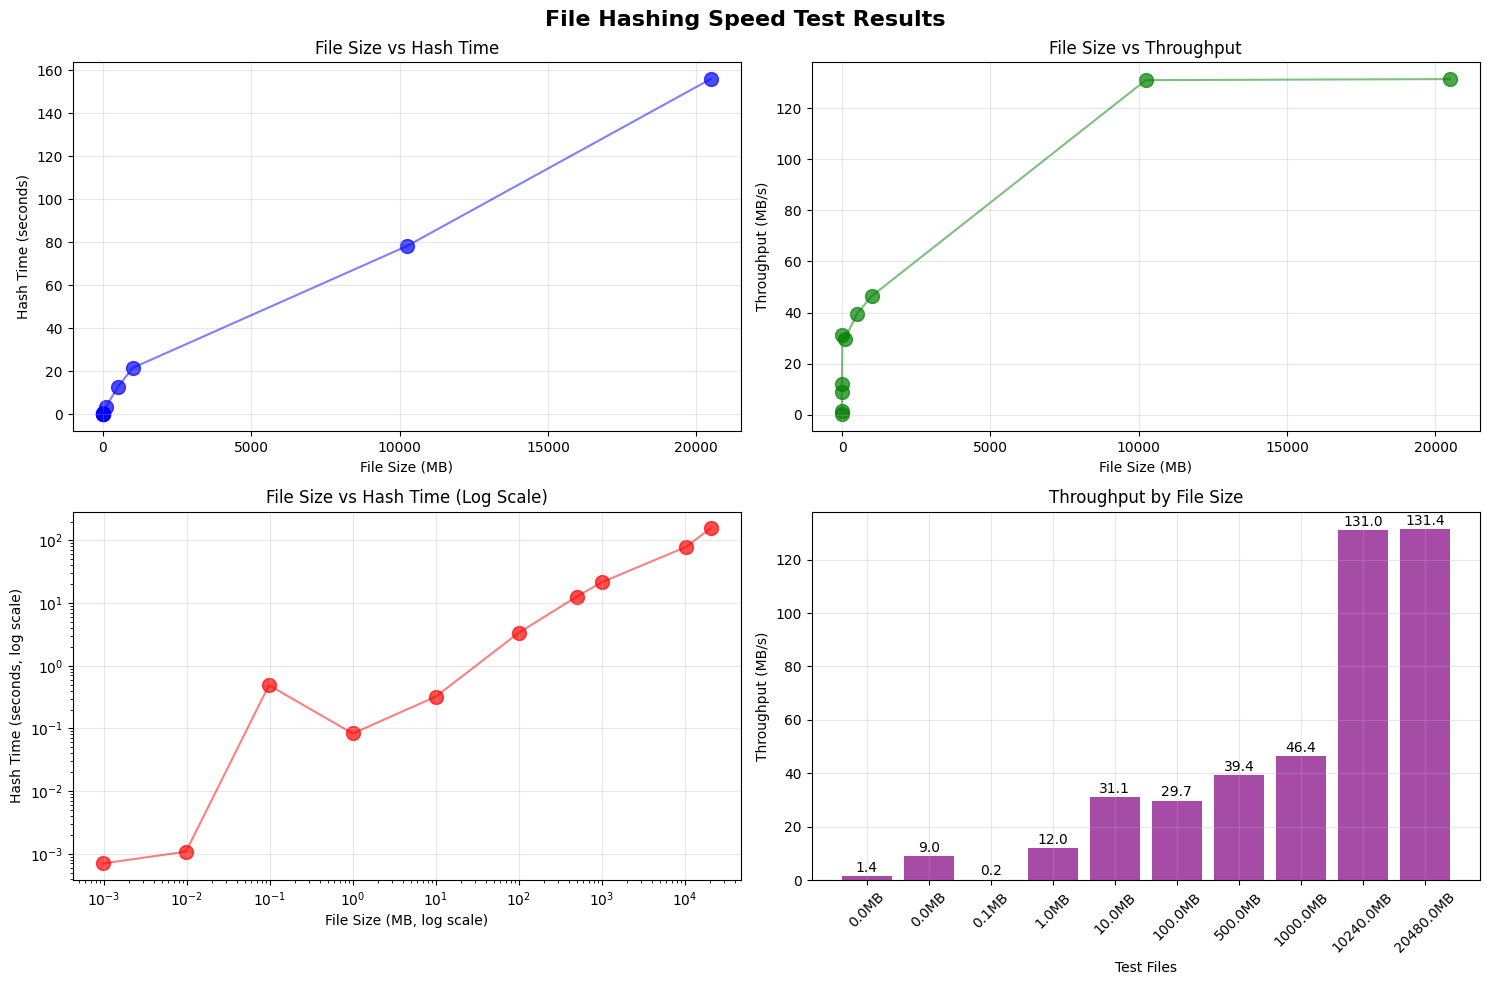

In [ ]:
# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('File Hashing Speed Test Results', fontsize=16, fontweight='bold')

# Plot 1: File Size vs Time
ax1.scatter(df['file_size_mb'], df['time_seconds'], s=100, alpha=0.7, color='blue')
ax1.plot(df['file_size_mb'], df['time_seconds'], 'b-', alpha=0.5)
ax1.set_xlabel('File Size (MB)')
ax1.set_ylabel('Hash Time (seconds)')
ax1.set_title('File Size vs Hash Time')
ax1.grid(True, alpha=0.3)

# Plot 2: File Size vs Throughput
ax2.scatter(df['file_size_mb'], df['throughput_mb_s'], s=100, alpha=0.7, color='green')
ax2.plot(df['file_size_mb'], df['throughput_mb_s'], 'g-', alpha=0.5)
ax2.set_xlabel('File Size (MB)')
ax2.set_ylabel('Throughput (MB/s)')
ax2.set_title('File Size vs Throughput')
ax2.grid(True, alpha=0.3)

# Plot 3: Log scale for file size vs time
ax3.scatter(df['file_size_mb'], df['time_seconds'], s=100, alpha=0.7, color='red')
ax3.plot(df['file_size_mb'], df['time_seconds'], 'r-', alpha=0.5)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('File Size (MB, log scale)')
ax3.set_ylabel('Hash Time (seconds, log scale)')
ax3.set_title('File Size vs Hash Time (Log Scale)')
ax3.grid(True, alpha=0.3)

# Plot 4: Bar chart of throughput
bars = ax4.bar(range(len(df)), df['throughput_mb_s'], color='purple', alpha=0.7)
ax4.set_xlabel('Test Files')
ax4.set_ylabel('Throughput (MB/s)')
ax4.set_title('Throughput by File Size')
ax4.set_xticks(range(len(df)))
ax4.set_xticklabels([f'{size:.1f}MB' for size in df['file_size_mb']], rotation=45)
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.5,
        f'{height:.1f}',
        ha='center',
        va='bottom',
    )

# Save the plot with notebook-specific naming
plot_file = results_dir / f'{notebook_name[:2]}_hash_speed_plot.png'
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f'Plot saved to: {plot_file.absolute()}')

plt.tight_layout()
plt.show()


## Analysis and Insights


In [ ]:
print('Hash Speed Test Analysis:')
print('=' * 40)
print(f'Total files tested: {len(df)}')
print(f'Total size processed: {df["file_size_mb"].sum():.2f} MB')
print(f'Average throughput: {df["throughput_mb_s"].mean():.2f} MB/s')
print(f'Best throughput: {df["throughput_mb_s"].max():.2f} MB/s')
print(f'Worst throughput: {df["throughput_mb_s"].min():.2f} MB/s')

print('\nFile Size vs Time Relationship:')
print(
    f'Smallest file ({df["file_size_mb"].min():.2f} MB): {df.loc[df["file_size_mb"].idxmin(), "time_seconds"]:.4f}s'
)
print(
    f'Largest file ({df["file_size_mb"].max():.2f} MB): {df.loc[df["file_size_mb"].idxmax(), "time_seconds"]:.4f}s'
)

print('\nThroughput by File Size:')
for _, row in df.iterrows():
    print(f'{row["file_size_mb"]:6.1f} MB: {row["throughput_mb_s"]:6.2f} MB/s')


Hash Speed Test Analysis:
Total files tested: 10
Total size processed: 32331.11 MB
Average throughput: 43.17 MB/s
Best throughput: 131.38 MB/s
Worst throughput: 0.20 MB/s

File Size vs Time Relationship:
Smallest file (0.00 MB): 0.0007s
Largest file (20480.00 MB): 155.8807s

Throughput by File Size:
   0.0 MB:   1.40 MB/s
   0.0 MB:   9.05 MB/s
   0.1 MB:   0.20 MB/s
   1.0 MB:  12.05 MB/s
  10.0 MB:  31.09 MB/s
 100.0 MB:  29.73 MB/s
 500.0 MB:  39.43 MB/s
1000.0 MB:  46.43 MB/s
10240.0 MB: 130.98 MB/s
20480.0 MB: 131.38 MB/s


In [ ]:
print('Hash Speed Test Analysis:')
print('=' * 40)
print(f'Total files tested: {len(df)}')
print(f'Total size processed: {df["file_size_mb"].sum():.2f} MB')
print(f'Average throughput: {df["throughput_mb_s"].mean():.2f} MB/s')
print(f'Best throughput: {df["throughput_mb_s"].max():.2f} MB/s')
print(f'Worst throughput: {df["throughput_mb_s"].min():.2f} MB/s')

print('\nFile Size vs Time Relationship:')
print(
    f'Smallest file ({df["file_size_mb"].min():.2f} MB): {df.loc[df["file_size_mb"].idxmin(), "time_seconds"]:.4f}s'
)
print(
    f'Largest file ({df["file_size_mb"].max():.2f} MB): {df.loc[df["file_size_mb"].idxmax(), "time_seconds"]:.4f}s'
)

print('\nThroughput by File Size:')
for _, row in df.iterrows():
    print(f'{row["file_size_mb"]:6.1f} MB: {row["throughput_mb_s"]:6.2f} MB/s')


Hash Speed Test Analysis:
Total files tested: 10
Total size processed: 32331.11 MB
Average throughput: 43.17 MB/s
Best throughput: 131.38 MB/s
Worst throughput: 0.20 MB/s

File Size vs Time Relationship:
Smallest file (0.00 MB): 0.0007s
Largest file (20480.00 MB): 155.8807s

Throughput by File Size:
   0.0 MB:   1.40 MB/s
   0.0 MB:   9.05 MB/s
   0.1 MB:   0.20 MB/s
   1.0 MB:  12.05 MB/s
  10.0 MB:  31.09 MB/s
 100.0 MB:  29.73 MB/s
 500.0 MB:  39.43 MB/s
1000.0 MB:  46.43 MB/s
10240.0 MB: 130.98 MB/s
20480.0 MB: 131.38 MB/s


## Chunk Size Analysis

Test different chunk sizes to find the optimal read buffer size for hashing performance.


In [ ]:
# Define chunk sizes to test
chunk_sizes = [
    1024,  # 1 KB
    4096,  # 4 KB
    8192,  # 8 KB (default)
    16384,  # 16 KB
    32768,  # 32 KB
    65536,  # 64 KB
    131072,  # 128 KB
    262144,  # 256 KB
    524288,  # 512 KB
    1048576,  # 1 MB
    2097152,  # 2 MB
]

print(f'Testing chunk sizes: {[f"{size:,} bytes" for size in chunk_sizes]}')

# Use a medium-sized test file for chunk size testing
test_file_size = 10 * 1024 * 1024  # 10 MB
chunk_test_file = test_dir / f'chunk_test_{test_file_size}.bin'

print(f'\nCreating test file: {chunk_test_file.name} ({test_file_size:,} bytes)')
create_test_file(chunk_test_file, test_file_size)


Testing chunk sizes: ['1,024 bytes', '4,096 bytes', '8,192 bytes', '16,384 bytes', '32,768 bytes', '65,536 bytes', '131,072 bytes', '262,144 bytes', '524,288 bytes', '1,048,576 bytes', '2,097,152 bytes']

Creating test file: chunk_test_10485760.bin (10,485,760 bytes)


In [ ]:
def calculate_file_hash_with_chunk_size(
    file_path: Path, chunk_size: int
) -> tuple[str, float]:
    """Calculate MD5 hash with specific chunk size and return hash and time taken."""
    hash_md5 = hashlib.md5()

    start_time = time.time()

    try:
        with open(file_path, 'rb') as f:
            for chunk in iter(lambda: f.read(chunk_size), b''):
                hash_md5.update(chunk)

        end_time = time.time()
        hash_value = hash_md5.hexdigest()
        time_taken = end_time - start_time

        return hash_value, time_taken

    except (IOError, OSError) as e:
        print(f'Error reading {file_path}: {e}')
        return '', 0.0


# Test different chunk sizes
chunk_results = []

print('Testing chunk sizes...')
for chunk_size in chunk_sizes:
    print(f'Testing chunk size: {chunk_size:,} bytes...')

    # Run multiple iterations for more accurate timing
    times = []
    for iteration in range(3):  # 3 iterations per chunk size
        hash_value, time_taken = calculate_file_hash_with_chunk_size(
            chunk_test_file, chunk_size
        )
        times.append(time_taken)

    # Calculate average time
    avg_time = sum(times) / len(times)
    throughput_mb_s = (test_file_size / (1024 * 1024)) / avg_time if avg_time > 0 else 0

    chunk_results.append(
        {
            'chunk_size_bytes': chunk_size,
            'chunk_size_kb': chunk_size / 1024,
            'time_seconds': avg_time,
            'throughput_mb_s': throughput_mb_s,
            'iterations': len(times),
            'min_time': min(times),
            'max_time': max(times),
            'std_dev': np.std(times) if len(times) > 1 else 0,
        }
    )

    print(f'  Average time: {avg_time:.4f}s, Throughput: {throughput_mb_s:.2f} MB/s')

print('\nChunk size testing completed!')


Testing chunk sizes...
Testing chunk size: 1,024 bytes...
  Average time: 0.0255s, Throughput: 392.32 MB/s
Testing chunk size: 4,096 bytes...
  Average time: 0.0173s, Throughput: 576.57 MB/s
Testing chunk size: 8,192 bytes...
  Average time: 0.0156s, Throughput: 639.86 MB/s
Testing chunk size: 16,384 bytes...
  Average time: 0.0148s, Throughput: 673.51 MB/s
Testing chunk size: 32,768 bytes...
  Average time: 0.0141s, Throughput: 710.23 MB/s
Testing chunk size: 65,536 bytes...
  Average time: 0.0138s, Throughput: 725.44 MB/s
Testing chunk size: 131,072 bytes...
  Average time: 0.0138s, Throughput: 724.19 MB/s
Testing chunk size: 262,144 bytes...
  Average time: 0.0141s, Throughput: 710.59 MB/s
Testing chunk size: 524,288 bytes...
  Average time: 0.0142s, Throughput: 704.86 MB/s
Testing chunk size: 1,048,576 bytes...
  Average time: 0.0141s, Throughput: 710.97 MB/s
Testing chunk size: 2,097,152 bytes...
  Average time: 0.0140s, Throughput: 716.05 MB/s

Chunk size testing completed!


In [ ]:
# Create DataFrame for chunk size results
chunk_df = pd.DataFrame(chunk_results)

# Display results
print('Chunk Size Performance Results:')
print('=' * 60)
chunk_display = chunk_df[
    ['chunk_size_kb', 'time_seconds', 'throughput_mb_s', 'std_dev']
].copy()
chunk_display['chunk_size_kb'] = chunk_display['chunk_size_kb'].round(1)
chunk_display['time_seconds'] = chunk_display['time_seconds'].round(4)
chunk_display['throughput_mb_s'] = chunk_display['throughput_mb_s'].round(2)
chunk_display['std_dev'] = chunk_display['std_dev'].round(4)
print(chunk_display.to_string(index=False))

# Find optimal chunk size
best_chunk_idx = chunk_df['throughput_mb_s'].idxmax()
best_chunk_size = chunk_df.loc[best_chunk_idx, 'chunk_size_bytes']
best_throughput = chunk_df.loc[best_chunk_idx, 'throughput_mb_s']

print(
    f'\nOptimal chunk size: {best_chunk_size:,} bytes ({best_chunk_size / 1024:.1f} KB)'
)
print(f'Best throughput: {best_throughput:.2f} MB/s')

# Save chunk size results with notebook-specific naming
chunk_results_file = results_dir / f'{notebook_name[:2]}_chunk_size_results.csv'
chunk_df.to_csv(chunk_results_file, index=False)
print(f'\nChunk size results saved to: {chunk_results_file.absolute()}')


Chunk Size Performance Results:
 chunk_size_kb  time_seconds  throughput_mb_s  std_dev
           1.0        0.0255           392.32   0.0101
           4.0        0.0173           576.57   0.0005
           8.0        0.0156           639.86   0.0005
          16.0        0.0148           673.51   0.0003
          32.0        0.0141           710.23   0.0002
          64.0        0.0138           725.44   0.0000
         128.0        0.0138           724.19   0.0002
         256.0        0.0141           710.59   0.0002
         512.0        0.0142           704.86   0.0001
        1024.0        0.0141           710.97   0.0001
        2048.0        0.0140           716.05   0.0001

Optimal chunk size: 65,536 bytes (64.0 KB)
Best throughput: 725.44 MB/s

Chunk size results saved to: /mnt/Dev/active_projects/neat_fs/notebooks/../data/tests/01_hash_speed_test/01_chunk_size_results.csv


Chunk size plot saved to: /mnt/Dev/active_projects/neat_fs/notebooks/../data/tests/01_hash_speed_test/01_chunk_size_plot.png


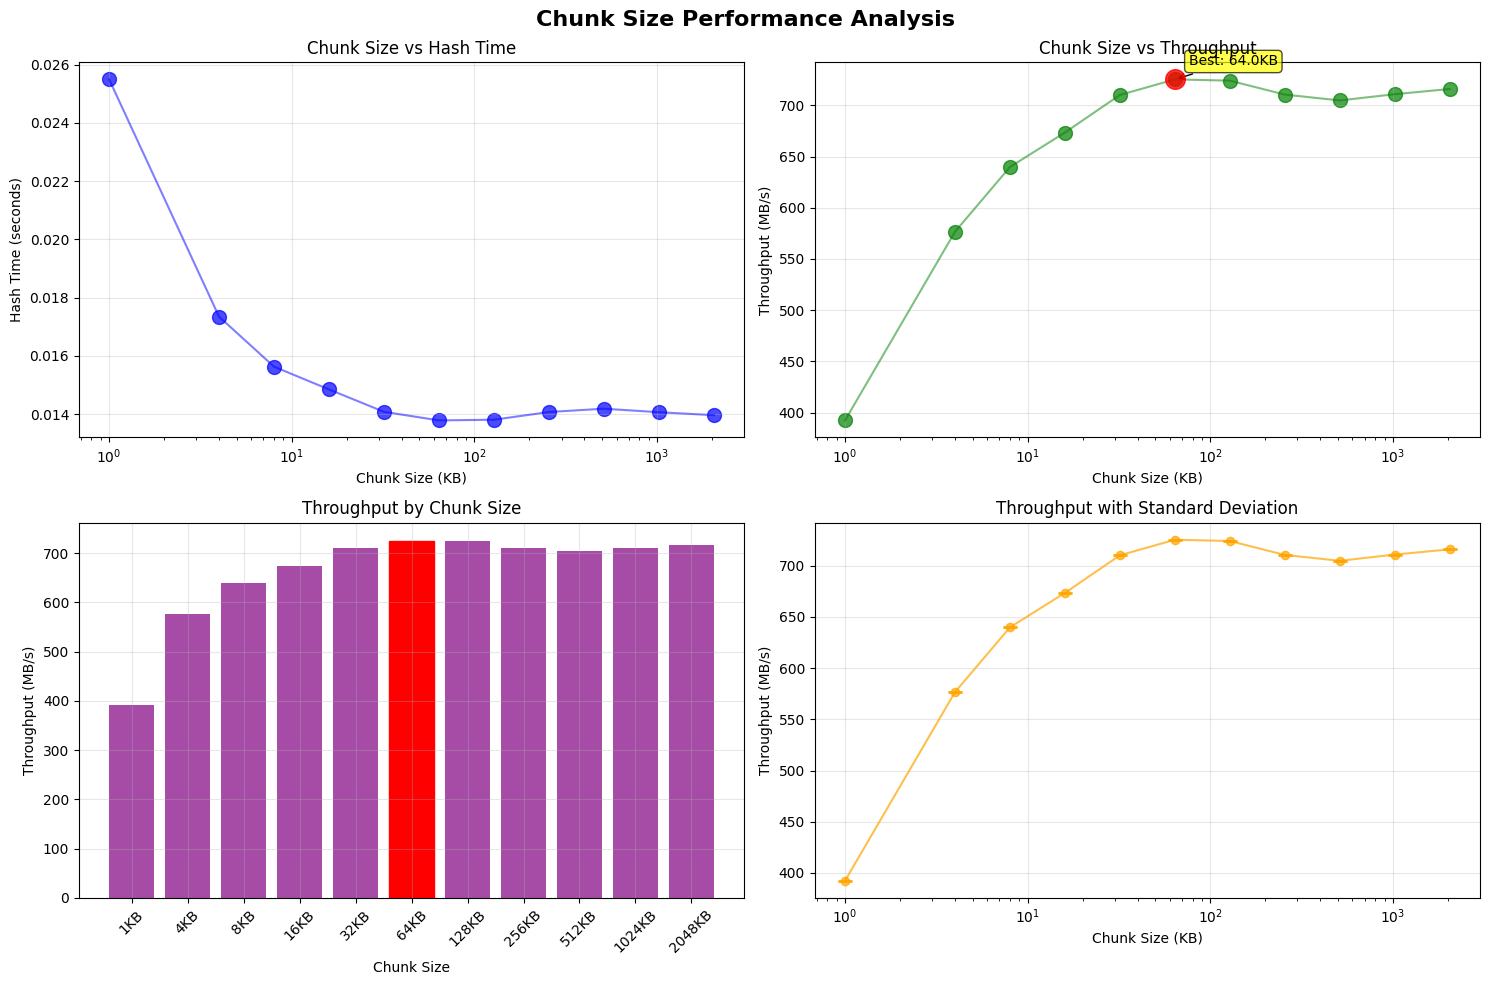

In [ ]:
# Create chunk size analysis plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Chunk Size Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Chunk Size vs Time
ax1.scatter(
    chunk_df['chunk_size_kb'], chunk_df['time_seconds'], s=100, alpha=0.7, color='blue'
)
ax1.plot(chunk_df['chunk_size_kb'], chunk_df['time_seconds'], 'b-', alpha=0.5)
ax1.set_xlabel('Chunk Size (KB)')
ax1.set_ylabel('Hash Time (seconds)')
ax1.set_title('Chunk Size vs Hash Time')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)

# Plot 2: Chunk Size vs Throughput
ax2.scatter(
    chunk_df['chunk_size_kb'],
    chunk_df['throughput_mb_s'],
    s=100,
    alpha=0.7,
    color='green',
)
ax2.plot(chunk_df['chunk_size_kb'], chunk_df['throughput_mb_s'], 'g-', alpha=0.5)
ax2.set_xlabel('Chunk Size (KB)')
ax2.set_ylabel('Throughput (MB/s)')
ax2.set_title('Chunk Size vs Throughput')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)

# Highlight the best chunk size
best_chunk_kb = chunk_df.loc[best_chunk_idx, 'chunk_size_kb']
ax2.scatter(best_chunk_kb, best_throughput, s=200, color='red', alpha=0.8, zorder=5)
ax2.annotate(
    f'Best: {best_chunk_kb:.1f}KB',
    xy=(best_chunk_kb, best_throughput),
    xytext=(10, 10),
    textcoords='offset points',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
)

# Plot 3: Bar chart of throughput
bars = ax3.bar(
    range(len(chunk_df)), chunk_df['throughput_mb_s'], color='purple', alpha=0.7
)
ax3.set_xlabel('Chunk Size')
ax3.set_ylabel('Throughput (MB/s)')
ax3.set_title('Throughput by Chunk Size')
ax3.set_xticks(range(len(chunk_df)))
ax3.set_xticklabels(
    [f'{size / 1024:.0f}KB' for size in chunk_df['chunk_size_bytes']], rotation=45
)
ax3.grid(True, alpha=0.3)

# Highlight the best bar
bars[best_chunk_idx].set_color('red')
bars[best_chunk_idx].set_alpha(1.0)

# Plot 4: Error bars showing standard deviation
ax4.errorbar(
    chunk_df['chunk_size_kb'],
    chunk_df['throughput_mb_s'],
    yerr=chunk_df['std_dev'],
    fmt='o-',
    capsize=5,
    capthick=2,
    alpha=0.7,
    color='orange',
)
ax4.set_xlabel('Chunk Size (KB)')
ax4.set_ylabel('Throughput (MB/s)')
ax4.set_title('Throughput with Standard Deviation')
ax4.set_xscale('log')
ax4.grid(True, alpha=0.3)

# Save the chunk size plot with notebook-specific naming
chunk_plot_file = results_dir / f'{notebook_name[:2]}_chunk_size_plot.png'
plt.savefig(chunk_plot_file, dpi=300, bbox_inches='tight')
print(f'Chunk size plot saved to: {chunk_plot_file.absolute()}')

plt.tight_layout()
plt.show()


## Chunk Size Analysis Summary

In [ ]:
print('Chunk Size Analysis Summary:')
print('=' * 30)
print(f'Test file size: {test_file_size / (1024 * 1024):.1f} MB')
print(f'Chunk sizes tested: {len(chunk_sizes)}')
print(
    f'Optimal chunk size: {best_chunk_size:,} bytes ({best_chunk_size / 1024:.1f} KB)'
)
print(f'Best throughput: {best_throughput:.2f} MB/s')

# Calculate performance improvement
worst_throughput = chunk_df['throughput_mb_s'].min()
worst_chunk_idx = chunk_df['throughput_mb_s'].idxmin()
worst_chunk_size = chunk_df.loc[worst_chunk_idx, 'chunk_size_bytes']

improvement = ((best_throughput - worst_throughput) / worst_throughput) * 100

print('\nPerformance comparison:')
print(
    f'Worst chunk size: {worst_chunk_size:,} bytes ({worst_chunk_size / 1024:.1f} KB)'
)
print(f'Worst throughput: {worst_throughput:.2f} MB/s')
print(f'Improvement: {improvement:.1f}% faster')

print('\nChunk size recommendations:')
print(f'- For maximum speed: {best_chunk_size:,} bytes')
print('- For memory efficiency: 8,192 bytes (8 KB)')
print('- For large files: 1,048,576 bytes (1 MB)')

# Clean up chunk test file
if chunk_test_file.exists():
    chunk_test_file.unlink()
    print(f'\nCleaned up chunk test file: {chunk_test_file.name}')


Chunk Size Analysis Summary:
Test file size: 10.0 MB
Chunk sizes tested: 11
Optimal chunk size: 65,536 bytes (64.0 KB)
Best throughput: 725.44 MB/s

Performance comparison:
Worst chunk size: 1,024 bytes (1.0 KB)
Worst throughput: 392.32 MB/s
Improvement: 84.9% faster

Chunk size recommendations:
- For maximum speed: 65,536 bytes
- For memory efficiency: 8,192 bytes (8 KB)
- For large files: 1,048,576 bytes (1 MB)

Cleaned up chunk test file: chunk_test_10485760.bin


## Cleanup Test Files


In [ ]:
# Clean up test files
print('Cleaning up test files...')
total_size = 0
for file_path in test_files:
    if file_path.exists():
        total_size += file_path.stat().st_size
        file_path.unlink()
        print(f'Deleted: {file_path.name}')

print(
    f'\nCleaned up {len(test_files)} files ({total_size / (1024 * 1024):.1f} MB total)'
)
print('Test files removed successfully!')


Cleaning up test files...
Deleted: test_file_0_1024.bin
Deleted: test_file_1_10240.bin
Deleted: test_file_2_102400.bin
Deleted: test_file_3_1048576.bin
Deleted: test_file_4_10485760.bin
Deleted: test_file_5_104857600.bin
Deleted: test_file_6_524288000.bin
Deleted: test_file_7_1048576000.bin
Deleted: test_file_8_10737418240.bin
Deleted: test_file_9_21474836480.bin

Cleaned up 10 files (32331.1 MB total)
Test files removed successfully!
